# Fitness Tracker Survival Analysis
Created by: Andy Luc

## Business case:
1. What is the average amount of time that MyFitnessPal users use the app, and do they use it consistently throughout?
2. Do users still keep using the program after meeting or not meeting their goal?

In [4]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Exploratory Data Analysis

In [ ]:
# Reading the data file
raw_df = pd.read_csv('data/mfp-diaries.tsv',
                  sep='\t',
                  header=None,
                  names=['userId','diary_date','food_entries','daily_goal'])

### Pickled files:
To save processing time when loading into dataframe.

In [ ]:
# raw_df.to_pickle('raw_df.pkl')
# total_goal_df.to_pickle('total_goal_df.pkl')
# survival_df.to_pickle('survival_df_base.pkl')

In [ ]:
raw_df = pd.read_pickle('raw_df.pkl')

In [ ]:
raw_df.head()

In [ ]:
#Number of unique users
len(raw_df['userId'].unique())

### Parsing lists of dictionaries within *daily_goals* column

In [ ]:
parse_df = raw_df.drop(['userId', 'diary_date','food_entries'], axis=1)

In [ ]:
parse_df.head()

In [ ]:
tg_dict = json.loads(parse_df['daily_goal'][0])
tg_dict

### Parse Functions

In [ ]:
"""Creates list of keys and values from the first dictionary, and zips them together"""
def daily_totals(tg_dict):    
    total_cols = [list(tg_dict.keys())[0] + "_" + x['name'].lower() 
                  for x in tg_dict['total']]
    total_values = [y['value'] 
                  for y in tg_dict['total']]

    total_dict = {}
    for col, val in zip(total_cols, total_values):
        total_dict[col] = val
    return total_dict

"""Creates list of keys and values from the second dictionary, and zips them together"""
def daily_goals(tg_dict):
    goal_cols = [list(tg_dict.keys())[1] + "_" + k['name'].lower()
                 for k in tg_dict['goal']]
    goal_values = [i['value']
                 for i in tg_dict['goal']]
    
    goal_dict = {}
    for col, val in zip(goal_cols, goal_values):
        goal_dict[col] = val
    return goal_dict

"""Combines new keys and values for 'Total' and 'Goals' into single dictionary"""
def merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res

"""Iterrates through entire parsed dataframe and appends merged rows"""
def final_parsed_dict():
    results = []
    for row in parse_df['daily_goal'].values:
        tg_dict = json.loads(row)
        results.append(merge(daily_goals(tg_dict), daily_totals(tg_dict)))
    return results

In [ ]:
tg_parse = pd.DataFrame(final_parsed_dict())

In [ ]:
tg_parse.head()

In [ ]:
concat_df = pd.concat([raw_df, tg_parse], axis=1)

In [ ]:
concat_df.isna().sum()

In [ ]:
total_goal_df = concat_df.drop(['food_entries','daily_goal','goal_calcium','goal_chol',
                                'goal_iron','goal_mon fat','goal_ply fat','goal_potass.',
                                'goal_sat fat','goal_trn fat','goal_vit a','goal_vit c',
                                'total_calcium','total_chol','total_iron','total_mon fat',
                                'total_ply fat','total_potass.','total_sat fat','total_trn fat',
                                'total_vit a','total_vit c'], axis=1)

In [ ]:
total_goal_df.fillna(0, inplace=True)

In [ ]:
total_goal_df['diary_date'] = pd.to_datetime(total_goal_df['diary_date'])

In [ ]:
total_goal_df.info()

## Labeling New Columns:
Create 1 column per dictionary in both total key and goal key

- total
    + total_calories
    + total_carbs
    + total_fat
    + total_fiber
    + total_protein
    + total_sodium
    + total_sugar
- goal
    + goal_calories
    + goal_carbs
    + goal_fat
    + goal_fiber
    + goal_protein
    + goal_sodium
    + goal_sugar


- **total_sum**: Total sum of input values for the day
- **goal_sum**: Total sum of goal values for the day
- **achievement**: Indicates whether or not a user has met their daily goal within a tolerance of 10%.
    - 1 = Succeed
    - 0 = Fail

In [ ]:
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

total_s = []
goal_s = []
for nutrient in nutrients:
    total_s.append(f'total_{nutrient}')
    goal_s.append(f'goal_{nutrient}')

In [ ]:
total_goal_df['total_sum'] = total_goal_df[total_s].apply(np.sum, axis=1)

total_goal_df['goal_sum'] = total_goal_df[goal_s].apply(np.sum, axis=1)

total_goal_df['achievement'] = np.where(abs((total_goal_df['total_sum'] - total_goal_df['goal_sum']) 
                                             / total_goal_df['goal_sum']) <= 0.1, 1, 0)

In [ ]:
total_goal_df.head()

## Survival Analysis

In [ ]:
days = total_goal_df['userId'].value_counts().sort_index()
days = pd.DataFrame(days).rename(columns={'userId': 'days'})
days.head()

In [ ]:
cols = total_goal_df.drop(['userId','diary_date'], axis=1).columns

condense_df = total_goal_df.groupby(['userId'])[cols].sum()

survival = pd.merge(days, condense_df, left_index=True, right_index=True)

In [ ]:
nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

for nutrient in nutrients:
    total = survival[f'total_{nutrient}']
    goal = survival[f'goal_{nutrient}']
    survival[f'{nutrient}_10_pct'] = np.where(abs((total - goal) / goal) <= 0.1, 1, 0)

In [ ]:
x = ['goal_calories','goal_carbs','goal_fat','goal_fiber','goal_protein',
     'goal_sodium','goal_sugar','total_calories','total_carbs','total_fat',
     'total_fiber','total_protein','total_sodium','total_sugar','total_sum','goal_sum']

survival_df = survival.drop(x, axis=1)

In [ ]:
survival_df.head()

### 14 day Churn:

In [5]:
survival_df = pd.read_pickle('survival_df_base.pkl')

In [6]:
from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.model_selection import train_test_split

In [8]:
survival_df['14day_churn'] = np.where(survival_df['days'] <= 14, 1, 0)

In [9]:
survival_df.head()

,days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct,14day_churn
1,174,68,1,0,1,0,0,1,1,0
2,60,11,1,1,0,0,0,0,0,0
3,7,2,0,0,0,0,0,0,0,1
4,27,4,0,0,0,0,0,0,0,0
5,179,58,1,0,0,0,1,0,1,0


In [34]:
cph = CoxPHFitter()
cph_train, cph_test = train_test_split(survival_df, test_size=0.2, random_state=1)
cph.fit(cph_train, 'days', '14day_churn')

<lifelines.CoxPHFitter: fitted with 7916 observations, 5809 censored>

In [35]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7916 observations, 5809 censored>
      duration col = 'days'
         event col = '14day_churn'
number of subjects = 7916
  number of events = 2107
partial log-likelihood = -15986.41
  time fit was run = 2019-06-28 22:25:57 UTC

---
                 coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
achievement     -0.68      0.51      0.02 -37.38 <0.005   1013.27       -0.72       -0.65
calories_10_pct  0.45      1.56      0.08   5.88 <0.005     27.90        0.30        0.59
carbs_10_pct     0.18      1.20      0.09   2.07   0.04      4.71        0.01        0.35
fat_10_pct       0.24      1.27      0.07   3.58 <0.005     11.49        0.11        0.37
fiber_10_pct     0.50      1.64      0.18   2.73   0.01      7.32        0.14        0.85
protein_10_pct   0.21      1.23      0.09   2.37   0.02      5.81        0.04        0.38
sodium_10_pct    0.57      1.77      0.09   6.44 <0.005     33.00        0.40        0.75
sugar_10_p

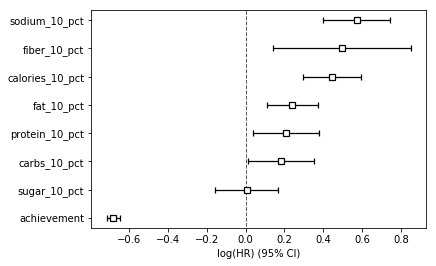

In [36]:
cph.plot()

In [54]:
fourteen_days = cph.fit(survival_df, duration_col='days', event_col='14day_churn')
fourteen_days.print_summary()

<lifelines.CoxPHFitter: fitted with 9896 observations, 7262 censored>
      duration col = 'days'
         event col = '14day_churn'
number of subjects = 9896
  number of events = 2634
partial log-likelihood = -20570.27
  time fit was run = 2019-06-29 00:26:59 UTC

---
                 coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
achievement     -0.69      0.50      0.02 -42.17 <0.005       inf       -0.72       -0.66
calories_10_pct  0.44      1.56      0.07   6.51 <0.005     33.65        0.31        0.58
carbs_10_pct     0.19      1.21      0.08   2.48   0.01      6.26        0.04        0.34
fat_10_pct       0.24      1.27      0.06   3.92 <0.005     13.45        0.12        0.36
fiber_10_pct     0.51      1.66      0.17   3.00 <0.005      8.54        0.18        0.84
protein_10_pct   0.23      1.26      0.08   2.99 <0.005      8.48        0.08        0.39
sodium_10_pct    0.54      1.72      0.08   6.67 <0.005     35.23        0.38        0.70
sugar_10_p

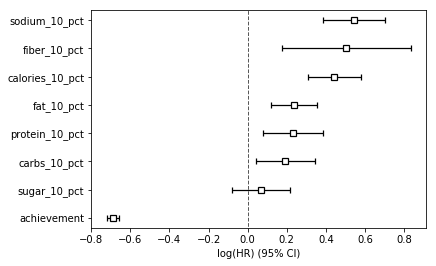

In [38]:
fourteen_days.plot()

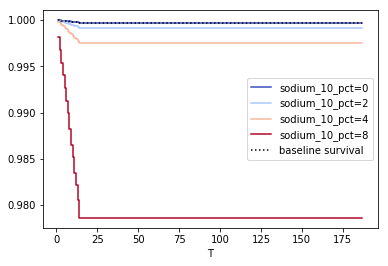

In [60]:
cph.plot_covariate_groups('sodium_10_pct', [0, 2, 4, 8], cmap='coolwarm')

### 45 day Churn:

In [61]:
survival_df['45day_churn'] = np.where(survival_df['days'] <= 45, 1, 0)
survival_df = survival_df.drop(['14day_churn'], axis=1)
survival_df.head()

,days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct,45day_churn
1,174,68,1,0,1,0,0,1,1,0
2,60,11,1,1,0,0,0,0,0,0
3,7,2,0,0,0,0,0,0,0,1
4,27,4,0,0,0,0,0,0,0,1
5,179,58,1,0,0,0,1,0,1,0


In [62]:
fortyfive_days = cph.fit(survival_df, duration_col='days', event_col='45day_churn')
fortyfive_days.print_summary()

<lifelines.CoxPHFitter: fitted with 9896 observations, 4713 censored>
      duration col = 'days'
         event col = '45day_churn'
number of subjects = 9896
  number of events = 5183
partial log-likelihood = -41253.04
  time fit was run = 2019-06-29 00:43:48 UTC

---
                 coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
achievement     -0.29      0.75      0.00 -59.96 <0.005       inf       -0.30       -0.28
calories_10_pct  0.33      1.39      0.05   7.06 <0.005     39.13        0.24        0.43
carbs_10_pct     0.15      1.17      0.05   3.03 <0.005      8.68        0.05        0.25
fat_10_pct       0.26      1.30      0.04   6.61 <0.005     34.56        0.19        0.34
fiber_10_pct     0.23      1.26      0.12   1.99   0.05      4.43        0.00        0.46
protein_10_pct   0.22      1.25      0.05   4.12 <0.005     14.70        0.12        0.32
sodium_10_pct    0.61      1.84      0.05  11.66 <0.005    101.91        0.51        0.72
sugar_10_p

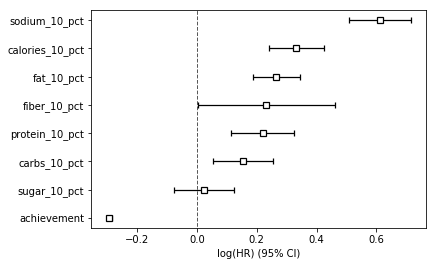

In [63]:
fortyfive_days.plot()

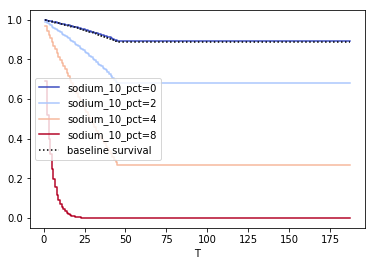

In [64]:
cph.plot_covariate_groups('sodium_10_pct', [0, 2, 4, 8], cmap='coolwarm')

### 90 day Churn:

In [10]:
survival_df['90day_churn'] = np.where(survival_df['days'] <= 90, 1, 0)
survival_df = survival_df.drop(['45day_churn'], axis=1)
survival_df.head()

,days,achievement,calories_10_pct,carbs_10_pct,fat_10_pct,fiber_10_pct,protein_10_pct,sodium_10_pct,sugar_10_pct,90day_churn
1,174,68,1,0,1,0,0,1,1,0
2,60,11,1,1,0,0,0,0,0,1
3,7,2,0,0,0,0,0,0,0,1
4,27,4,0,0,0,0,0,0,0,1
5,179,58,1,0,0,0,1,0,1,0


In [11]:
ninety_days = cph.fit(survival_df, duration_col='days', event_col='90day_churn')
ninety_days.print_summary()

<lifelines.CoxPHFitter: fitted with 9896 observations, 2538 censored>
      duration col = 'days'
         event col = '90day_churn'
number of subjects = 9896
  number of events = 7358
partial log-likelihood = -59136.16
  time fit was run = 2019-06-28 19:47:10 UTC

---
                 coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
achievement     -0.15      0.86      0.00 -67.24 <0.005       inf       -0.15       -0.14
calories_10_pct  0.29      1.34      0.04   7.77 <0.005     46.80        0.22        0.36
carbs_10_pct     0.09      1.09      0.04   2.18   0.03      5.09        0.01        0.17
fat_10_pct       0.27      1.31      0.03   8.29 <0.005     53.00        0.20        0.33
fiber_10_pct     0.18      1.20      0.09   2.02   0.04      4.53        0.01        0.36
protein_10_pct   0.17      1.18      0.04   3.76 <0.005     12.54        0.08        0.26
sodium_10_pct    0.49      1.63      0.04  11.86 <0.005    105.29        0.41        0.57
sugar_10_p

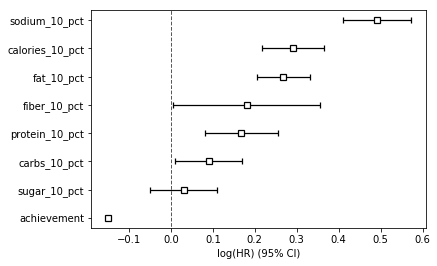

In [12]:
ninety_days.plot()

## Time Series Analysis

In [ ]:
total_goal_df.head()

In [ ]:
irrelevant = ['goal_calories','goal_carbs','goal_fat','goal_fiber','goal_protein',
              'goal_sodium','goal_sugar','total_calories','total_carbs','total_fat',
              'total_fiber','total_protein','total_sodium','total_sugar','achievement']

time_df = total_goal_df.drop(irrelevant, axis=1)

In [ ]:
time_df.head()

In [ ]:
time_df['tg_diff'] = round(abs((time_df['total_sum'] - time_df['goal_sum'])/time_df['goal_sum']), 3)

In [ ]:
# time_df['tg_diff'] = pd.Series(["{0:.2f}%".format(val * 100) for val in time_df['tg_diff']])

In [ ]:
time_df = time_df.drop(['total_sum','goal_sum'], axis=1)

In [ ]:
time_df.set_index('diary_date', inplace=True)

In [ ]:
time_df.head()

In [ ]:
new_time_df = pd.DataFrame(time_df[(time_df['userId']==1)|(time_df['userId']==2)])

In [ ]:
new_time_df.head()

In [ ]:
by_label = new_time_df.groupby('userId')

for name, group in by_label:
    plt.plot(group['tg_diff'], label=name)

plt.legend()
plt.show()

### Saving and reading from json:

In [ ]:
# total_goal_df.to_json('data/mfp-goals.json', orient='records', lines=True)

In [ ]:
# total_goal_df = pd.read_json('data/mfp-goals.json', lines=True)

# total_goal_df['diary_date'] = pd.to_datetime(total_goal_df['diary_date'])

# total_goal_df.head()

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score

In [ ]:
# #Setting X and y variables, then Train Test Split
# X = final_df.drop(['achievement','diary_date','userId','goal_sum','total_sum',
#                    'goal_calories','goal_carbs','goal_fat','goal_fiber',
#                    'goal_protein','goal_sodium','goal_sugar'], axis=1)
# y = final_df.achievement

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
# loreg = LogisticRegression(solver='lbfgs', max_iter=1000)
# loreg.fit(X_train, y_train)
# loreg_preds = loreg.predict(X_test)

In [ ]:
# def print_metrics(y, loreg_preds):
#     print("Precision Score: {}".format(precision_score(y, loreg_preds)))
#     print("Recall Score: {}".format(recall_score(y, loreg_preds)))
#     print("Accuracy Score: {}".format(accuracy_score(y, loreg_preds)))
#     print("F1 Score: {}".format(f1_score(y, loreg_preds)))
    
# print_metrics(y_test, loreg_preds)

In [ ]:
# nutrients = ['calories','carbs','fat','fiber','protein','sodium','sugar']

# total_s = []
# goal_s = []
# for nutrient in nutrients:
#     total_s.append(f'total_{nutrient}')
#     survival['total_sum'] = survival[total_s].apply(np.sum, axis=1)
#     goal_s.append(f'goal_{nutrient}')
#     survival['goal_sum'] = survival[goal_s].apply(np.sum, axis=1)

In [ ]:
# json_dict.keys()[0]
# Gives Error: 'dict_keys' object does not support indexing, hence needs to be set to a list to iterate.

In [ ]:
# df = pd.DataFrame([[1, 4],
#                    [2, 5],
#                    [3, 6]],
#                   columns=["a", "b"])
# df

In [ ]:
# df["c"] = df.apply(np.sum, axis=1)
# df